<a id='start'></a>
# Reti neurali con Tensor Flow

In questo notebook vengono presentati degli esercizi sulle reti neurali con Tensor Flow.

Provate a svolgere il seguente esercizio:<br>
1) [pp -> H -> ZZ -> 4lepton](#section1)<br>

<a id='section1'></a>
## pp -> H -> ZZ -> 4lepton

Creare una rete neurale per analizzare i dati prodotti dagli studi di pp -> H -> ZZ -> 4lepton nel contesto delle ricerche mono-Higgs da parte della collaborazione CMS. I programmi usano le ntuple ridotte (con il nome dell'albero radice HZZ4LeptonsAnalysisReduced) create con Root.

In [1]:
import uproot
import numpy as np
import pandas as pd
import h5py

In [25]:
treename = 'HZZ4LeptonsAnalysisReduced'
filename ='ntuple_4mu_bkg.root'

upfile = uproot.open(filename)
params = upfile[treename].arrays() # dictionary of NumPy arrays

VARS = ['f_massjj']
df = pd.DataFrame(params, columns=VARS)

In [40]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = 'HZZ4LeptonsAnalysisReduced'

VARS = ['f_mass4l', 'f_massjj']
upfile_VV = uproot.open('ntuple_4mu_VV.root')
upfile_BKG = uproot.open('ntuple_4mu_bkg.root')


df_VV = pd.DataFrame(np.array(upfile_VV[treename].arrays(VARS)))
df_BKG = pd.DataFrame(np.array(upfile_BKG[treename].arrays(VARS)))

# cut out undefined variables VARS[0] and VARS[1] > -999
df_VV = df_VV[(df_VV[VARS[0]] > -999) & (df_VV[VARS[1]] > -999)]
df_BKG = df_BKG[(df_BKG[VARS[0]] > -999) & (df_BKG[VARS[1]] > -999)] 

# add isSignal variable
df_VV['isSignal'] = np.ones(len(df_VV)) 
df_BKG['isSignal'] = np.zeros(len(df_BKG))

df_all = pd.concat([df_VV, df_BKG])
df_all

,f_mass4l,f_massjj,isSignal
0,125.077103,1300.426880,1.0
1,124.238113,437.221863,1.0
3,124.480667,1021.744080,1.0
4,124.919464,1101.381958,1.0
7,125.049065,498.717194,1.0
...,...,...,...
58056,197.383133,114.257278,0.0
58057,218.065582,106.195534,0.0
58060,89.288086,53.661579,0.0
58062,146.756577,71.162025,0.0


Creiamo una rete densa, con un singolo livello nascosto completamente connesso con lo stesso numero di neuroni delle variabili di input.

Possiamo quindi usare la funzione di attivazione `sigmoide` per produrre un'uscita di probabilità nell'intervallo da 0 a 1.

Infine usiamo la funzione di loss `binary_crossentropy` durante l'allenamento, una funzione di perdita standard per problemi di classificazione binaria.

Infine utimmizziamo il modello con l'algoritmo Adam per il grandient descend.

In [41]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU

from sklearn.preprocessing import StandardScaler, LabelBinarizer

In [43]:
X = df_all[['f_mass4l', 'f_massjj']]
y = df_all['isSignal']

X = StandardScaler().fit_transform(X)
y = LabelBinarizer().fit_transform(y)

In [44]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [50]:
y_test

array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [51]:
model = Sequential()

model.add(Dense(128, input_dim=2))
model.add(ReLU())

model.add(Dense(units=64))
model.add(ReLU())

model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Train on 16590 samples, validate on 4148 samples
Epoch 1/20
16590/16590 [==============================] - 2s 146us/sample - loss: 0.1713 - accuracy: 0.9498 - val_loss: 0.0763 - val_accuracy: 0.9790
Epoch 2/20
16590/16590 [==============================] - 1s 88us/sample - loss: 0.0610 - accuracy: 0.9820 - val_loss: 0.0543 - val_accuracy: 0.9853
Epoch 3/20
16590/16590 [==============================] - 1s 85us/sample - loss: 0.0541 - accuracy: 0.9832 - val_loss: 0.0516 - val_accuracy: 0.9860
Epoch 4/20
16590/16590 [==============================] - 1s 83us/sample - loss: 0.0534 - accuracy: 0.9832 - val_loss: 0.0506 - val_accuracy: 0.9863
Epoch 5/20
16590/16590 [==============================] - 2s 92us/sample - loss: 0.0524 - accuracy: 0.9834 - val_loss: 0.0485 - val_accuracy: 0.9851
Epoch 6/20
16590/16590 [==============================] - 2s 101us/sample - loss: 0.0515 - accuracy: 0.9832 - val_loss: 0.0479 - val_accuracy: 0.9872
Epoch 7/20
16590/16590 [==============================]

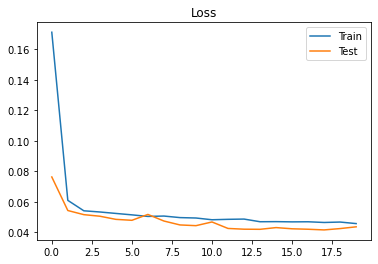

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['Train','Test'])
plt.show()

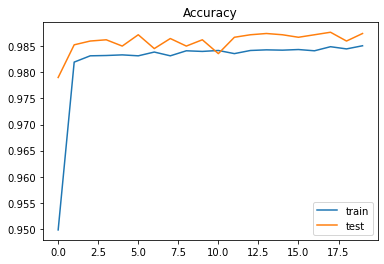

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['train', 'test'])
plt.show()